<a id="1"></a> <br>
## Import Libraries and the Data

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/shee35/ML-Dataset/main/newcsv.csv', parse_dates=True)


<a id="2"></a> <br>
## Descriptive Analysis

In [ ]:
data.head()

,Dates,Current,Temporal,Spatial,Derived
0,4/26/2020,3,3.0,74.360000,3.922437
1,4/27/2020,3,3.0,76.692308,4.016444
2,4/28/2020,3,3.0,86.000000,4.391603
3,4/29/2020,3,3.0,88.423077,4.489269
4,4/30/2020,3,3.0,92.346154,4.647394


In [ ]:
print(data.columns)
print(data.shape)

Index(['Dates', 'Current', 'Temporal', 'Spatial', 'Derived'], dtype='object')
(521, 5)


In [ ]:
data

,Dates,Current,Temporal,Spatial,Derived
0,4/26/2020,3,3.0,74.360000,3.922437
1,4/27/2020,3,3.0,76.692308,4.016444
2,4/28/2020,3,3.0,86.000000,4.391603
3,4/29/2020,3,3.0,88.423077,4.489269
4,4/30/2020,3,3.0,92.346154,4.647394
...,...,...,...,...,...
516,9/24/2021,66771,66676.2,174665.769200,27615.043900
517,9/25/2021,66838,66729.4,174754.538500,27636.591170
518,9/26/2021,66853,66773.8,174842.730800,27650.513130
519,9/27/2021,66868,66812.2,174716.038500,27654.602250


In [ ]:
data['Derived']=data['Derived'].ewm(span=2).mean()

In [ ]:
data

,Dates,Current,Temporal,Spatial,Derived
0,4/26/2020,3,3.0,74.360000,3.922437
1,4/27/2020,3,3.0,76.692308,3.992942
2,4/28/2020,3,3.0,86.000000,4.268938
3,4/29/2020,3,3.0,88.423077,4.417661
4,4/30/2020,3,3.0,92.346154,4.571449
...,...,...,...,...,...
516,9/24/2021,66771,66676.2,174665.769200,27606.309926
517,9/25/2021,66838,66729.4,174754.538500,27626.497422
518,9/26/2021,66853,66773.8,174842.730800,27642.507894
519,9/27/2021,66868,66812.2,174716.038500,27650.570798


In [ ]:
data = data.drop(['Dates', 'Current','Temporal',
       'Spatial'],axis=1)

<a id="24"></a> <br>
## Fearure Scaling

In [ ]:
data

,Derived
0,3.922437
1,3.992942
2,4.268938
3,4.417661
4,4.571449
...,...
516,27606.309926
517,27626.497422
518,27642.507894
519,27650.570798


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
data_scaled= sc.fit_transform(data)
data_scaled

array([[0.00000000e+00],
       [2.54902191e-06],
       [1.25273020e-05],
       [1.79041888e-05],
       [2.34641862e-05],
       [3.19197943e-05],
       [4.09707800e-05],
       [4.96644007e-05],
       [8.81714939e-05],
       [1.07693853e-04],
       [1.22981773e-04],
       [1.37306776e-04],
       [1.47948019e-04],
       [1.58818583e-04],
       [1.92408618e-04],
       [2.14366337e-04],
       [2.38506396e-04],
       [2.62813925e-04],
       [2.84785935e-04],
       [3.15483462e-04],
       [3.46070630e-04],
       [3.75231827e-04],
       [4.20123391e-04],
       [4.53072612e-04],
       [4.88453416e-04],
       [5.52976189e-04],
       [6.34699324e-04],
       [7.08587308e-04],
       [7.86193079e-04],
       [8.76811770e-04],
       [9.46268206e-04],
       [1.03120472e-03],
       [1.13176863e-03],
       [1.25131153e-03],
       [1.35384037e-03],
       [1.46770927e-03],
       [1.55969204e-03],
       [1.64591232e-03],
       [1.75599718e-03],
       [1.86501914e-03],


In [ ]:
data_scaled.shape

(521, 1)

<a id="25"></a> <br>
## Creating LSTM input data

In order to use LSTM, our input and output data should have a specific shape. It was a bit complicated for me when I was first introduced to LSTM, but I found [this](https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e) comprehensive article to fully understand what was going on. In a nutshell, the input and output data in an LSTM model is a three-dimensional array where the first dimension represents **the number of samples (or batch size)** like the number of rows of data in a two-dimensional setting, the second dimension stands for **time steps** which indicates the amount of time that we want to go back through time, and the third dimension shows **the number of features (or input dimension)** that we want to include in the model for every element in our batch. So, it is like [number_of_samples, time_steps, input_dim]. The below image is retrieved from the mentioned article and could be a good illustration of the LSTM input and output data shape.
![](https://miro.medium.com/max/665/1*AQKRJsRdWx2HZ85H1yWoKw.png)

Sometimes we prefer to choose the validation set by ourselves. In this case, in the below code, you can pass a value in the range of (0, 1) for the validation_split_percentage when you are calling the create_data function, and use the below code to fit the model:

- model.fit(train_X, train_y, validation_data=(val_x, val_y))  # manually splitting

In my case, I rathered to use the built-in parameter (validation_split) in the fit method of the Keras library.  It considers a fraction of the training data as the validation set to evaluate loss and metrics at the end of each epoch as follow:

- model.fit(train_X, train_y, validation_split=0.3)  # automatically splitting

Here, at each point of the time, we will consider price and volume as our attributes in input_dim, and 25 days as our time_steps.

In [ ]:
# Creating a data structure (it does not work when you have only one feature)
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []
    
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])
    
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))
    
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]
    
    # if you want to choose the validation set by yourself, uncomment the below code.
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val =  x_data[split_train_validation_starting_point:split_training_test_starting_point]                                             
    
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]
    
    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [ ]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_scaled, n_future=1, n_past=25, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(397, 25, 1)
(99, 25, 1)
(397, 1)
(99, 1)


<a id="3"></a> <br>
## Train LSTM Model

In [ ]:
# ------------------LSTM-----------------------
'''''
regressor = Sequential()
regressor.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=256, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')
#regressor.fit(X_train, y_train, epochs=100, batch_size=64)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = regressor.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=64, callbacks=[es])
'''''

"''\nregressor = Sequential()\nregressor.add(LSTM(units=256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))\nregressor.add(Dropout(0.2))\n\nregressor.add(LSTM(units=256, return_sequences=False))\nregressor.add(Dropout(0.2))\nregressor.add(Dense(units=1, activation='linear'))\nregressor.compile(optimizer='adam', loss='mse')\n#regressor.fit(X_train, y_train, epochs=100, batch_size=64)\n\nes = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)\n#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)\n# fit model\nhistory = regressor.fit(X_train, y_train, validation_split=0.3, epochs=1000, batch_size=64, callbacks=[es])\n"

<a id="4"></a> <br>
## Hyperparameter Tunning


We have two important terms in machine learning referred to as **model parameter** and **model hyperparamer**. So, first of all, what is a hyperparameter, and what is a parameter? Based on [here](https://www.datacamp.com/community/tutorials/parameter-optimization-machine-learning-models),

- A model **model hyperparameter** is a configuration that is external to the model and whose value cannot be estimated from the data and a **model parameter** is a configuration variable that is internal to the model and whose value can be estimated from the given data.

In the other words, a hyperparameter is used to construct the structure of the model and cannot be learned from the data and its value is set before the learning process begins. Therefore, hyperparameters are like the settings of an algorithm that can be adjusted to optimize performance and prevent overfitting. This is exactly what we do in the hyperparameter tuning. We try to choose a set of optimal hyperparameters for a learning algorithm to enhance the performance of the model. There are two frequently used methods to perform hyperparameter tunning called 1)Grid Search and 2)Random Search. In this notebook, I have used the former one because of its simplicity to implement and at the same time, its powerful performance. More information on both of the methods can be found in [here](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85).

<a id="42"></a> <br>
## Grid Search

Grid search is a traditional method to perform hyperparameter tunning. It basically works by defining a subset of candidate values for each hyperparameter, and training all the possible combination of the hyperparameters. Then, each possible fitted model is evaluated on a validation set, and the best configuration of the hyperparameter will be choosed at the end.

<a id="43"></a> <br>
## Early Stopping and Callback

Since in the Grid Search, we have to train an LSTM model for each combination, it may take so much time to fit all the models and choose the best combination of the hyperparameters. One of the ways that we can prevent this from happening is through using Early Stopping and Callbacks. The idea here is to track a measure (like validation loss) and whenever a stopping criterion (like no improvement in the monitored measure value in successive steps, reaching a pre-specified limit for that measure, or a pre-specified increment in that measure) is satisfied, we can stop the training process. The measure that we are using here is validation loss since the validation set is not used in the training process. [This](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) article is one of the best articles that I've read about using Early Stopping to halt the training of a model at the right time. In the below, I copied and pasted the parts that I found important:

> 1. **es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)** ****-->**** Often, the first sign of no further improvement may not be the best time to stop training. This is because the model may coast into a plateau of no improvement or even get slightly worse before getting much better. We can account for this by adding a delay to the trigger in terms of the number of epochs on which we would like to see no improvement. This can be done by setting the “patience” argument.
    
> 2. **es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)** **-->** By default, any change in the performance measure, no matter how fractional, will be considered an improvement. You may want to consider an improvement that is a specific increment, such as 1 unit for mean squared error or 1% for accuracy. This can be specified via the “min_delta” argument.

> 3. **es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.4)** **-->**  Finally, it may be desirable to only stop training if performance stays above or below a given threshold or baseline. For example, if you have familiarity with the training of the model (e.g. learning curves) and know that once a validation loss of a given value is achieved that there is no point in continuing training. This can be specified by setting the “baseline” argument.
    
> 4. **mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1)** **-->** The EarlyStopping callback will stop training once triggered, but the model at the end of training may not be the model with best performance on the validation dataset. An additional callback is required that will save the best model observed during training for later use. This is the ModelCheckpoint callback.

In [ ]:
# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    print(print(np.asarray(possible_combinations).shape))
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse')

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=1000, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        
    return hist

In [ ]:
config = [[False, True], [False, True], [False, True], [128, 256], [128, 64], [0.1, 0.2]]   

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)  # change x_train shape

[(False, False, False, 128, 128, 0.1), (False, False, False, 128, 128, 0.2), (False, False, False, 128, 64, 0.1), (False, False, False, 128, 64, 0.2), (False, False, False, 256, 128, 0.1), (False, False, False, 256, 128, 0.2), (False, False, False, 256, 64, 0.1), (False, False, False, 256, 64, 0.2), (False, False, True, 128, 128, 0.1), (False, False, True, 128, 128, 0.2), (False, False, True, 128, 64, 0.1), (False, False, True, 128, 64, 0.2), (False, False, True, 256, 128, 0.1), (False, False, True, 256, 128, 0.2), (False, False, True, 256, 64, 0.1), (False, False, True, 256, 64, 0.2), (False, True, False, 128, 128, 0.1), (False, True, False, 128, 128, 0.2), (False, True, False, 128, 64, 0.1), (False, True, False, 128, 64, 0.2), (False, True, False, 256, 128, 0.1), (False, True, False, 256, 128, 0.2), (False, True, False, 256, 64, 0.1), (False, True, False, 256, 64, 0.2), (False, True, True, 128, 128, 0.1), (False, True, True, 128, 128, 0.2), (False, True, True, 128, 64, 0.1), (False, 

<a id="44"></a> <br>
## Choosing the Best Model

In [ ]:
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
6,False,False,False,256,64,0.1,0.000905,0.006379
5,False,False,False,256,128,0.2,0.001247,0.007802
4,False,False,False,256,128,0.1,0.001400,0.008859
7,False,False,False,256,64,0.2,0.001277,0.009639
0,False,False,False,128,128,0.1,0.001711,0.009903
...,...,...,...,...,...,...,...,...
51,True,True,False,128,64,0.2,0.012413,0.139631
50,True,True,False,128,64,0.1,0.013348,0.149934
58,True,True,True,128,64,0.1,0.015558,0.175970
59,True,True,True,128,64,0.2,0.016286,0.182837


<a id="5"></a> <br>
## Results

In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')

Best Combination: 
 first_additional_layer = False
 second_additional_layer = False
 third_additional_layer = False
 n_neurons = 256
 n_batch_size = 64
 dropout = 0.1


In [ ]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])
# print(first_additional_layer)
# print(second_additional_layer)
# print(third_additional_layer)
# print(n_neurons)
# print( n_batch_size)
# print( dropout)

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

if third_additional_layer:
    regressor.add(GRU(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

file_path = 'best_model.h5'

mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

regressor.fit(X_train, y_train, validation_split=0.3, epochs=100, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)


Epoch 00001: val_loss improved from inf to 0.04172, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.04172 to 0.00072, saving model to best_model.h5

Epoch 00003: val_loss did not improve from 0.00072

Epoch 00004: val_loss improved from 0.00072 to 0.00056, saving model to best_model.h5

Epoch 00005: val_loss did not improve from 0.00056

Epoch 00006: val_loss did not improve from 0.00056

Epoch 00007: val_loss did not improve from 0.00056

Epoch 00008: val_loss did not improve from 0.00056

Epoch 00009: val_loss did not improve from 0.00056

Epoch 00010: val_loss did not improve from 0.00056

Epoch 00011: val_loss did not improve from 0.00056

Epoch 00012: val_loss did not improve from 0.00056

Epoch 00013: val_loss did not improve from 0.00056

Epoch 00014: val_loss did not improve from 0.00056

Epoch 00015: val_loss did not improve from 0.00056

Epoch 00016: val_loss did not improve from 0.00056

Epoch 00017: val_loss did not improve from 0.00056

Epoch 00018: v

In [ ]:
regressor.evaluate(X_test, y_test)

4/4 [==============================] - 0s 49ms/step - loss: 0.0073


0.0073105040937662125

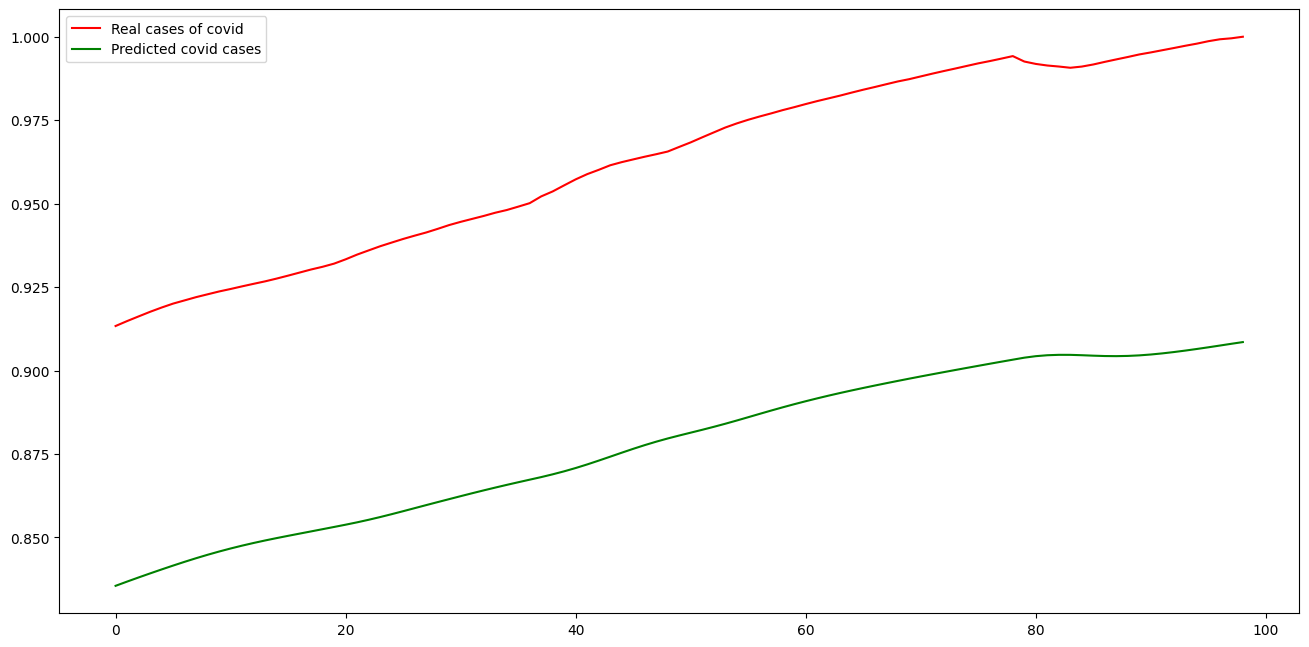

In [ ]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Real cases of covid')
plt.plot(y_pred, color='green', label = 'Predicted covid cases')
plt.legend(loc='best')

In [ ]:
data = pd.DataFrame(y_pred, columns = ['Column_A'])

In [ ]:
data

,Column_A
0,0.835517
1,0.836786
2,0.838024
3,0.839235
4,0.840422
...,...
94,0.906465
95,0.906968
96,0.907490
97,0.908020


In [ ]:
d1=sc.inverse_transform(data)
d1

array([[23114.064],
       [23149.154],
       [23183.402],
       [23216.898],
       [23249.723],
       [23281.803],
       [23312.982],
       [23342.873],
       [23371.324],
       [23398.182],
       [23423.432],
       [23447.018],
       [23469.105],
       [23489.873],
       [23509.492],
       [23528.314],
       [23546.715],
       [23565.021],
       [23583.44 ],
       [23601.912],
       [23620.61 ],
       [23640.205],
       [23661.295],
       [23683.844],
       [23707.693],
       [23732.395],
       [23757.572],
       [23782.795],
       [23807.715],
       [23832.379],
       [23856.926],
       [23881.164],
       [23904.852],
       [23927.879],
       [23950.354],
       [23972.148],
       [23993.562],
       [24014.885],
       [24037.945],
       [24062.883],
       [24090.188],
       [24119.914],
       [24151.523],
       [24184.05 ],
       [24216.951],
       [24249.135],
       [24279.775],
       [24308.451],
       [24334.967],
       [24359.46 ],


In [ ]:
data.to_csv('data.csv')

In [ ]:
data1 = pd.DataFrame(y_test, columns = ['Column_A'])

In [ ]:
data1.to_csv('data1.csv')

## **Plotting**

In [ ]:
d3 = regressor.predict(X_train)
d3 = sc.inverse_transform(d3)
y_train= sc.inverse_transform(y_train)

In [ ]:
d2=sc.inverse_transform(y_test)

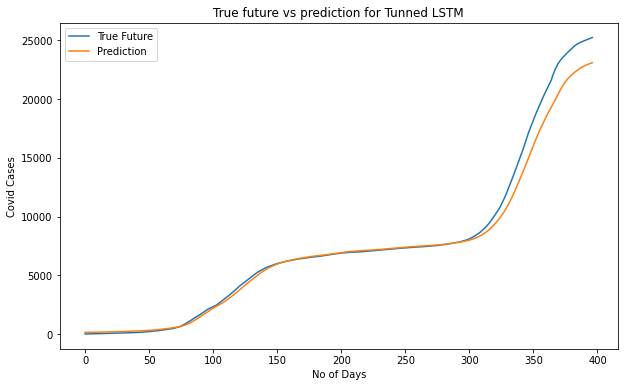

In [ ]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('No of Days')
    plt.ylabel('Covid Cases')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
plot_future(d3, 'Tunned LSTM', y_train)

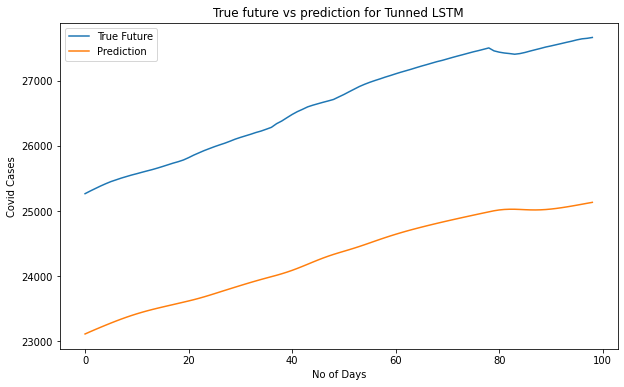

In [ ]:
plot_future(d1, 'Tunned LSTM', d2)

# **Errors**

### **(i) Root mean Square error**

In [ ]:
from math import sqrt

# Calculate root mean squared error
def rmse_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		prediction_error = predicted[i] - actual[i]
		sum_error += (prediction_error ** 2)
	mean_error = sum_error / float(len(actual))
	return sqrt(mean_error)

# Test RMSE
rmse = rmse_metric(y_test, y_pred)
print(rmse)

0.08550148616112767


### **(ii) Mean Absolute Error** 

In [ ]:
# Calculate mean absolute error
def mae_metric(actual, predicted):
	sum_error = 0.0
	for i in range(len(actual)):
		sum_error += abs(predicted[i] - actual[i])
	return sum_error / float(len(actual))

# Test RMSE
mae = mae_metric(y_test, y_pred)
print(mae)

[0.08537041]


### **(iii) Mean squared Error**

In [ ]:
MSE= np.square(np.subtract(y_test,y_pred)).mean()
print(MSE)

0.007310504135761505
